In [1]:
import pandas as pd
import rioxarray 
import os
import xarray as xr
import dask
from datetime import datetime
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES' 

# other requirements
# * hvplot requires datashader package 

In [2]:
## This script provides some examples of accessing and processing data with cloud native methods
# 1. Reads composite data from the S3 bucket using xarray's lazy loading
# 2. Provides instructions on bulk data download from S3 bucket to local machine
# 3. Plots composited bands
# 4. Calcualtes NDVI and visualizes results on an interactive plot
# 5. Plots true color composited image generated from R,G,B bands
# 6. Plots a time history of composited data for a pixel

# NOTES
# 1. If no HLS data is found for the 30 or 10 day interval, an empty file called 'No granules found' included
# 2. scaling factor for composited raster is 0.0001, but not reflected in the metadata yet
# 3. No-data value is set to -9999 in the raster, but metadata says scale_factor=1 (NEED TO BE CORRECTED) 
# 4. Additional layers available in the composited granule: std dev, Validcount, and Day of Year (DOY)  

# Useful links
# NASA Openscapes tutorials: https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/tree/main/tutorials

In [3]:
# # Example aws commands to bulk download data to local machine 

# # List the contents of the bucket
# !aws s3 ls s3://{bucket_name} --no-sign-request 

# # create prefix and list contents 
# prefix = f'test-composite-{composite_alg}/{tile}/{year}/'
# print(prefix)
# !aws s3 ls s3://{bucket_name}/{prefix} --no-sign-request 

# # Download granule data to local
# composite_granule_name = "HLS.M30.T10TGP.2018001.2018030.2.0"
# prefix = f'test-composite-{composite_alg}/{tile}/{year}/{composite_granule_name}/'
# destination = "/home/Downloads/" ## update this 

# # List files
# !aws s3 ls s3://{bucket_name}/{prefix} --no-sign-request
# # Download files    
# !aws s3 sync s3://{bucket_name}/{prefix} {destination}/{composite_granule_name} --no-sign-request

In [4]:
# define some useful variables
bucket_name = 'hls-composite-bdec'
tile = "15QYA"#, "15QYA" 
year = "2020"

## Composite algorithm. 
## initial data: 'median-30day', 'median-10day', 'max-30day'
## Step-1 data : 'max-10day', 'median-10day', 'max-monthly', 'median-monthly'
composite_alg = "median-monthly"
no_data_value = -9999

In [5]:
def get_list_of_files_from_s3(bucket_name, prefix):
    """
        function to get s3 file links from bucket and prefix
    """
    import boto3
    from botocore import UNSIGNED
    from botocore.client import Config

    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)
    
    files = []
    for obj in bucket.objects.filter(Prefix=prefix):
        files.append(f"s3://{bucket_name}/"+obj.key)
    return files

def gen_prefix(composite_alg="median-10day", year="2018", tile="15QYA", granule_name=""):
    """
        construct prefix from variables
        UPDATE the prefix if needed
    """
    ## prefix for 'initial' results 
    # return f'test-composite-{composite_alg}/{tile}/{year}/{granule_name}'
   
    ## Step-1 prototype results 
    return  f'step-1-evaluation-prototype-data/composite-{composite_alg}/{tile}/{year}/{granule_name}'

## Process granules 
prefix = gen_prefix(composite_alg=composite_alg, year=year, tile=tile)
s3_file_links = get_list_of_files_from_s3(bucket_name, prefix)

In [6]:
# print first few links in the list 
s3_file_links[:10]

['s3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.Blue.std.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.Blue.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.DOY.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.EVI.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.Fmask.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001

In [7]:
# subset links to separate bands
s3_file_links_red = [f for f in s3_file_links if 'Red.tif' in f]
s3_file_links_blue = [f for f in s3_file_links if 'Blue.tif' in f]
s3_file_links_green = [f for f in s3_file_links if 'Green.tif' in f]
s3_file_links_nir = [f for f in s3_file_links if 'NIR_Narrow.tif' in f]

In [8]:
#check first few links
s3_file_links_red[:10]

['s3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020001.2020031.2.0/HLS.M30.T15QYA.2020001.2020031.2.0.Red.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020032.2020060.2.0/HLS.M30.T15QYA.2020032.2020060.2.0.Red.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020061.2020091.2.0/HLS.M30.T15QYA.2020061.2020091.2.0.Red.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020092.2020121.2.0/HLS.M30.T15QYA.2020092.2020121.2.0.Red.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020122.2020152.2.0/HLS.M30.T15QYA.2020122.2020152.2.0.Red.tif',
 's3://hls-composite-bdec/step-1-evaluation-prototype-data/composite-median-monthly/15QYA/2020/HLS.M30.T15QYA.2020153.2020182

In [9]:
# Read a single file from the list using rioxarray
example_file = s3_file_links_red[1]
hls_da = rioxarray.open_rasterio(example_file, chuncks=True, mask_and_scale=True)
hls_da = hls_da.squeeze('band', drop=True)
# hls_da_cleaned = hls_da.where(hls_da!=-9999) # remove no-data values manually
#hls_da_scaled = hls_da_cleaned/10_000 # scale surface reflectance by 10,000

In [10]:
hls_da

<xarray.DataArray (y: 3660, x: 3660)> Size: 54MB
[13395600 values with dtype=float32]
Coordinates:
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

In [11]:
# Create an interactive plot
hls_da.hvplot.image(x='x', 
                           y='y', 
                           cmap='gray', # colormaps -> https://holoviews.org/user_guide/Colormaps.html
                           rasterize=True, 
                           width=800, height=600, 
                           colorbar=True).opts(title=example_file.split('/')[-1])

/usr/local/lib/python3.10/site-packages/pyct/__init__.py:8: FutureWarning: param.version.Version has been deprecated and will be removed in a future version.
  __version__ = str(param.version.Version(fpath=__file__, archive_commit="$Format:%h$",
/usr/local/lib/python3.10/site-packages/param/version.py:200: FutureWarning: param.version.run_cmd has been deprecated and will be removed in a future version.
  remotes = run_cmd([cmd, 'remote', '-v'],
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Image   [x,y]   (value)

In [12]:
# create time var from file names
def start_time_index_from_filenames(file_links):
    '''
    Helper function to create a 'time' index 
    use composite start as the time coord in datetime format  
    '''
    start = [f.split('.')[3] for f in file_links] 
    end  = [f.split('.')[4] for f in file_links]
    
    start_dt = [datetime.strptime(date, "%Y%j").date() for date in start]

    return start_dt

def combined_time_index_from_filenames(file_links):
    '''
    Helper function to create a 'time' index 
    combining composite start and end time
    note: time index is NOT in datetime format  
    '''
    start = [f.split('.')[3] for f in file_links] 
    end  = [f.split('.')[4] for f in file_links]
    
    combined_time = [f"{item1}-{item2}" for item1, item2 in zip(start,end)]
    return combined_time

# time_coord = start_time_index_from_filenames(s3_file_links_red)
time_coord = combined_time_index_from_filenames(s3_file_links_red)
time_coord

['2020001-2020031',
 '2020032-2020060',
 '2020061-2020091',
 '2020092-2020121',
 '2020122-2020152',
 '2020153-2020182',
 '2020183-2020213',
 '2020214-2020244',
 '2020245-2020274',
 '2020275-2020305',
 '2020306-2020335',
 '2020336-2020366']

In [13]:
# specify chunk size for processing
# chunks=dict(band=1, x=512, y=512)
chunks='auto'

In [14]:
# create da for each band
def create_xr_dataset_from_files(file_links, band_name):
    da = xr.concat(
    [rioxarray.open_rasterio(f, chunks=chunks, mask_and_scale=True).squeeze('band', drop=True) for f in file_links],
    dim=time_coord)
    da = da.where(da!=no_data_value) # remove no-data values manually
    da = da.rename({'concat_dim': 'time'})
    da.name = band_name
    return da

In [15]:
# create xarray DataArray with all the bands
hls_da_red = create_xr_dataset_from_files(s3_file_links_red, 'R')
hls_da_blue = create_xr_dataset_from_files(s3_file_links_blue, 'B')
hls_da_green = create_xr_dataset_from_files(s3_file_links_green, 'G')
hls_da_nir = create_xr_dataset_from_files(s3_file_links_nir, 'NIR')

In [16]:
hls_da_green

<xarray.DataArray 'G' (time: 12, y: 3660, x: 3660)> Size: 643MB
dask.array<where, shape=(12, 3660, 3660), dtype=float32, chunksize=(1, 3660, 3660), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
    spatial_ref  int64 8B 0
  * time         (time) object 96B '2020001-2020031' ... '2020336-2020366'
Attributes:
    AREA_OR_POINT:  Area

In [17]:
# calculate NDVI from red and nir bands
ndvi = (hls_da_nir - hls_da_red)/(hls_da_nir + hls_da_red)
ndvi.name = "NDVI"
ndvi

<xarray.DataArray 'NDVI' (time: 12, y: 3660, x: 3660)> Size: 643MB
dask.array<truediv, shape=(12, 3660, 3660), dtype=float32, chunksize=(1, 3660, 3660), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
    spatial_ref  int64 8B 0
  * time         (time) object 96B '2020001-2020031' ... '2020336-2020366'

In [18]:
# load ndvi data. can take a while for large datasets
ndvi_data = ndvi.load()

/usr/local/lib/python3.10/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [19]:
# visualize ndvi composite using an interactive plot (zoom, pan, etc)
# use 'time' dropdown on the right to select the composite period
ndvi_data.hvplot.image(x='x', 
                       y='y', 
                       rasterize=True, 
                       width=800, height=600, 
                       colorbar=True, cmap='greens').opts(clabel="NDVI", title=composite_alg,clim=(ndvi.values.min(), ndvi.values.max()))

:DynamicMap   [time]
   :Image   [x,y]   (NDVI)

In [20]:
# Visualize RGB composite image
hls_ds_rgb = xr.merge([hls_da_red, hls_da_green, hls_da_blue], compat='override').chunk("auto") 
rgb = hls_ds_rgb[['R', 'G','B']].squeeze().to_array()

plotting 2020001-2020031
plotting 2020032-2020060
plotting 2020061-2020091
plotting 2020092-2020121
plotting 2020122-2020152
plotting 2020153-2020182
plotting 2020183-2020213
plotting 2020214-2020244
plotting 2020245-2020274
plotting 2020275-2020305
plotting 2020306-2020335
plotting 2020336-2020366


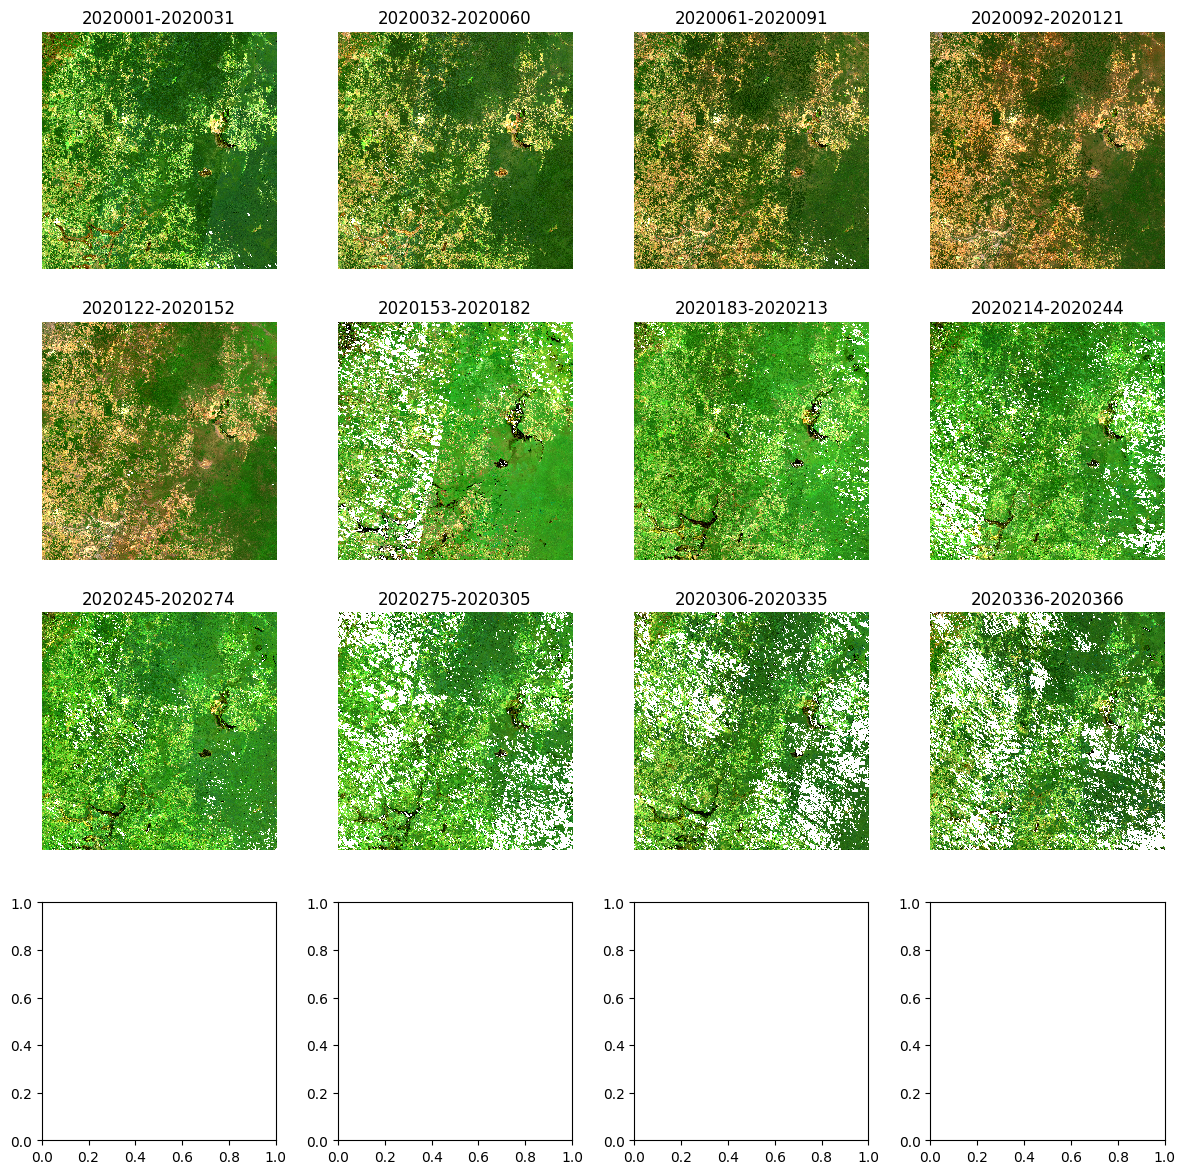

In [21]:
# Plotting RGB takes a while
fig, ax = plt.subplots(4, 4) ## change if needed
fig.set_size_inches(12, 12)
ax_flat = ax.flatten()

for i, (label, sub_da) in enumerate(rgb.groupby('time')):
     print(f'plotting {label}')
     ax = ax_flat[i]
     sub_da.squeeze().plot.imshow(ax=ax, robust=True)
     ax.set_title(f'{label}')
     ax.set_axis_off()
fig.tight_layout()
plt.show()

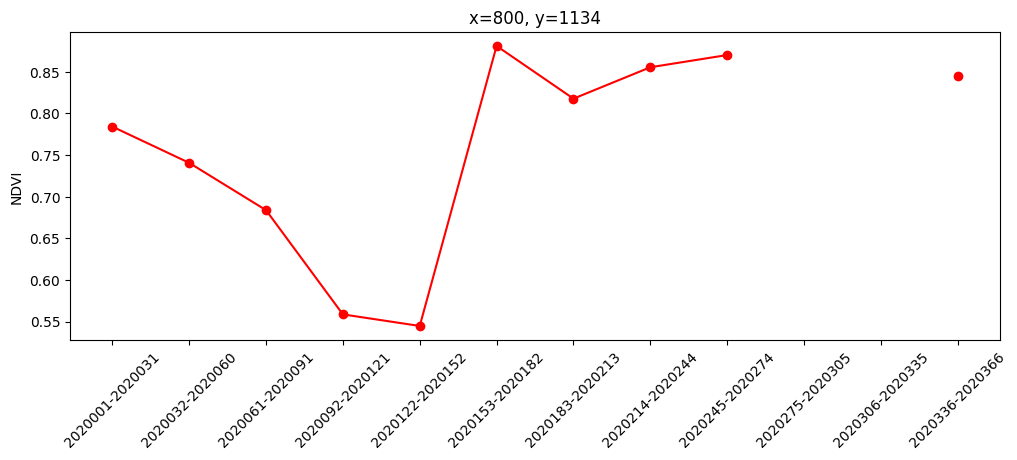

In [22]:
# Plot a simple time history of NDVI for a pixel

# Define pixel x and y index
pixel_xidx = 800
pixel_yidx = 1134 

# Plot pixel ndvi 
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 4)

# Since the 'time' coordinates in the da are NOT in datetime format, hack to get xlabels
pixel_ndvi = ndvi.squeeze().isel(x=pixel_xidx, y=pixel_yidx).values
x_positions = np.arange(0, len(pixel_ndvi))

ax.plot(x_positions, pixel_ndvi, 'ro-')
ax.set_ylabel('NDVI')
ax.set_title(f"x={pixel_xidx}, y={pixel_yidx}")
plt.xticks(x_positions, labels=ndvi['time'].values, rotation=45) 
plt.show()